In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# This line is needed to use CUDA on my linux box
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/usr/lib/cuda'

2023-10-01 18:48:50.176292: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-01 18:48:50.196571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 18:48:50.478942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
#Load and preprocess Tiny Imagenet data
# rescale images and set aside 20% of data for validation
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

tiny_imagenet_train_gen = data_gen.flow_from_directory(
    '/home/robert/Dev/cs5870-assignment-1/data/tiny-imagenet-200/train',
    target_size=(64, 64),  # Resize to the actual image size
    batch_size=64,
    class_mode='categorical',
    subset='training'  # Specify this is for training data
)

# Validation generator: Similarly, for validation
tiny_imagenet_val_gen = data_gen.flow_from_directory(
    '/home/robert/Dev/cs5870-assignment-1/data/tiny-imagenet-200/train',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='validation'  # Specify this is for validation data
)

Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


In [7]:
# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 200)               1638600   
                                                                 
Total params: 25226312 (96.23 MB)
Trainable params: 25173192 (96.03 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [8]:
# Model evaluation using the validation generator
val_loss, val_acc = model.evaluate(tiny_imagenet_val_gen, steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size)
print("Validation Accuracy:", val_acc)

312/312 [==============================] - 2s 6ms/step - loss: 5.5308 - accuracy: 0.0041
Validation Accuracy: 0.00410657050088048


## About 1/200 out of the box, which is exactly what we'd expect. Let's try fine tuning with a frozen base since that worked best last time

In [9]:
# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 Tiny Imagenet model with frozen base
frozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=5,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

# Optional: Unfreeze some layers of the base model and continue training
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the ResNet50 Tiny Imagenet model
unfrozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=10,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

Epoch 1/5
   1/1250 [..............................] - ETA: 24:02 - loss: 5.3981 - accuracy: 0.0156

2023-10-01 17:37:24.616729: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564d81f1d460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-01 17:37:24.616741: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-10-01 17:37:24.619089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-01 17:37:24.657874: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 [==============================] - 10s 7ms/step - loss: 5.1699 - accuracy: 0.0152 - val_loss: 5.0092 - val_accuracy: 0.0255
Epoch 2/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.9295 - accuracy: 0.0319 - val_loss: 4.8584 - val_accuracy: 0.0407
Epoch 3/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.8136 - accuracy: 0.0440 - val_loss: 4.7772 - val_accuracy: 0.0475
Epoch 4/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7464 - accuracy: 0.0499 - val_loss: 4.7355 - val_accuracy: 0.0523
Epoch 5/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7070 - accuracy: 0.0534 - val_loss: 4.7064 - val_accuracy: 0.0563
Epoch 1/10
1250/1250 [==============================] - 11s 7ms/step - loss: 4.9514 - accuracy: 0.0437 - val_loss: 4.7901 - val_accuracy: 0.0480
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7128 - accuracy: 0.0533 - val_loss: 4.7308 - val_accuracy: 0.0516
Epoch

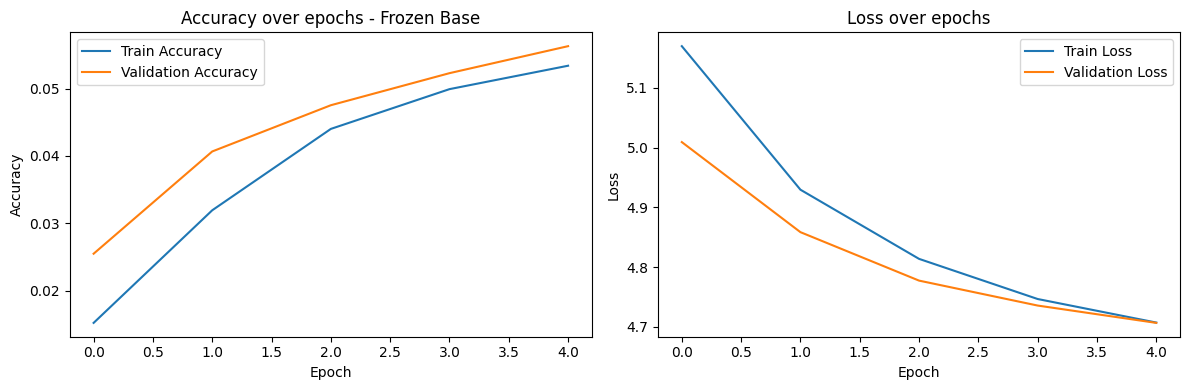

In [10]:
# Plotting Accuracy and Loss for frozen portion of training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(frozen_imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(frozen_imagenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs - Frozen Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(frozen_imagenet_history.history['loss'], label='Train Loss')
plt.plot(frozen_imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

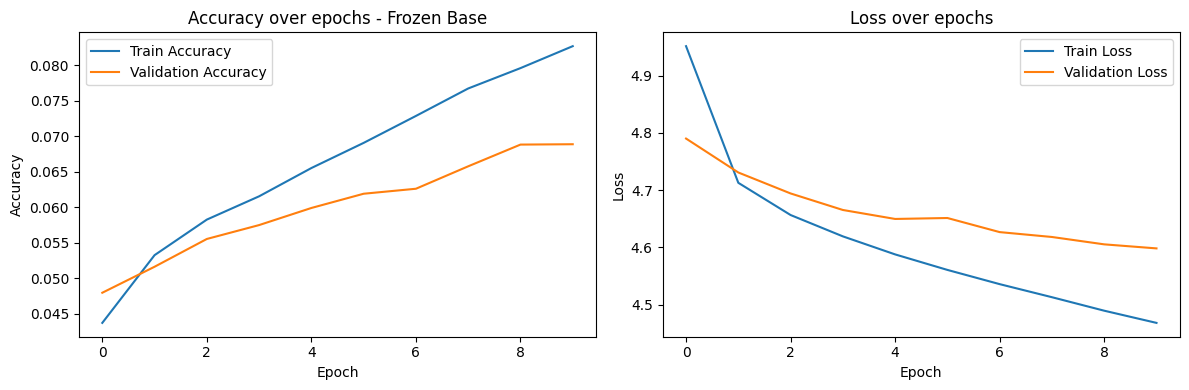

In [11]:
# Plotting Accuracy and Loss for frozen portion of training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unfrozen_imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(unfrozen_imagenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs - Frozen Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(unfrozen_imagenet_history.history['loss'], label='Train Loss')
plt.plot(unfrozen_imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Well, it's learning... very slowly. You know, ResNet50 is a very deep neural network and we're only unfreezing a small portion of it. Let's try training with 25 layers unfrozen and see what happens

In [12]:
# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 Tiny Imagenet model with frozen base
frozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=5,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

# Optional: Unfreeze some layers of the base model and continue training
for layer in base_model.layers[-25:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the ResNet50 Tiny Imagenet model
unfrozen_imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=10,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

Epoch 1/5
1250/1250 [==============================] - 10s 7ms/step - loss: 5.1486 - accuracy: 0.0157 - val_loss: 5.0028 - val_accuracy: 0.0279
Epoch 2/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.9468 - accuracy: 0.0311 - val_loss: 4.8920 - val_accuracy: 0.0366
Epoch 3/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.8470 - accuracy: 0.0393 - val_loss: 4.8091 - val_accuracy: 0.0450
Epoch 4/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7791 - accuracy: 0.0459 - val_loss: 4.7622 - val_accuracy: 0.0513
Epoch 5/5
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7444 - accuracy: 0.0494 - val_loss: 4.7516 - val_accuracy: 0.0507
Epoch 1/10
1250/1250 [==============================] - 12s 8ms/step - loss: 5.2154 - accuracy: 0.0263 - val_loss: 4.9623 - val_accuracy: 0.0331
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 4.8223 - accuracy: 0.0434 - val_loss: 4.8401 - val_accuracy: 0.

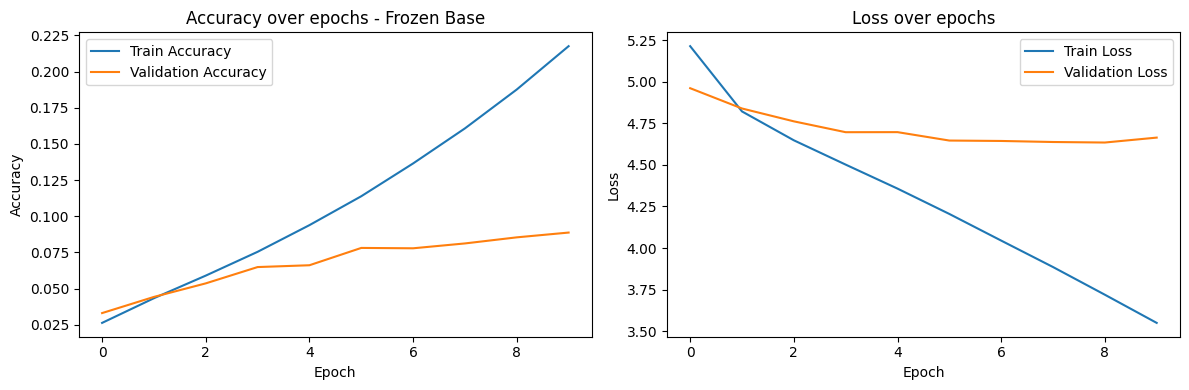

In [13]:
# Plotting Accuracy and Loss for frozen portion of training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unfrozen_imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(unfrozen_imagenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs - Frozen Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(unfrozen_imagenet_history.history['loss'], label='Train Loss')
plt.plot(unfrozen_imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## It's a little better, but it appears to be overfitting. Maybe it's a diminishing gradient. The architecture of ResNet50 has skips and some complex stuff - maybe freezing layers is bad. Let's try unfreezing the entire network and training that way

In [15]:
# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 Tiny Imagenet model with frozen base
imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=5,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

Epoch 1/5
1250/1250 [==============================] - 34s 18ms/step - loss: 4.1241 - accuracy: 0.1245 - val_loss: 4.2914 - val_accuracy: 0.1139
Epoch 2/5
1250/1250 [==============================] - 22s 18ms/step - loss: 3.5148 - accuracy: 0.2147 - val_loss: 4.0295 - val_accuracy: 0.1569
Epoch 3/5
1250/1250 [==============================] - 21s 17ms/step - loss: 3.1849 - accuracy: 0.2696 - val_loss: 3.8355 - val_accuracy: 0.1845
Epoch 4/5
1250/1250 [==============================] - 21s 17ms/step - loss: 2.9250 - accuracy: 0.3165 - val_loss: 13.2676 - val_accuracy: 0.0086
Epoch 5/5
1250/1250 [==============================] - 21s 17ms/step - loss: 2.8802 - accuracy: 0.3244 - val_loss: 4.4512 - val_accuracy: 0.1322


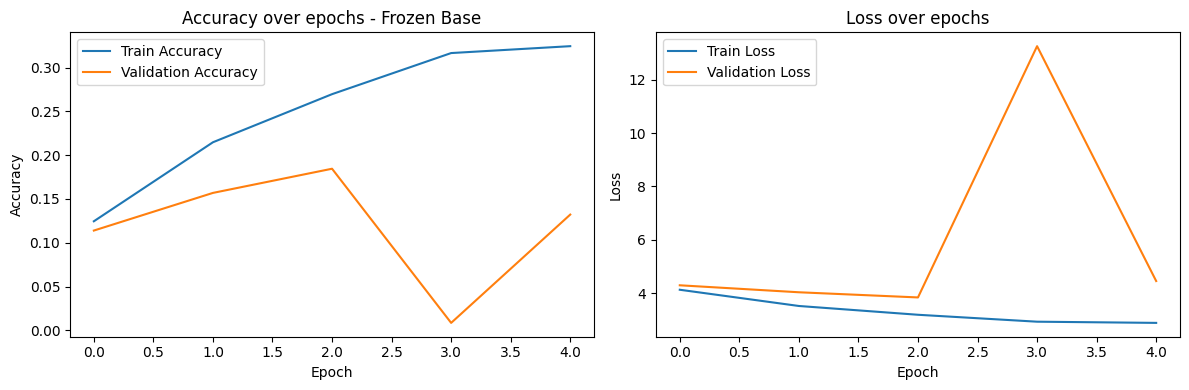

In [16]:
# Plotting Accuracy and Loss for frozen portion of training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(imagenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs - Frozen Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(imagenet_history.history['loss'], label='Train Loss')
plt.plot(imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## It's working better, but epoch 4 was weird. And we've still got some overfitting happening. Let's do another experiment with some more dense layers and dropout to try and address the overfitting. We'll do 10 epochs this time

In [18]:
# Create callback for saving model
checkpoint = ModelCheckpoint('../models/resnet50_tiny_imagenet.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.4),
    Dense(256, activation='relu'),
    Dropout(.4),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 Tiny Imagenet model with frozen base
imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=25,
    validation_data=tiny_imagenet_val_gen,
    callbacks=[checkpoint]
)

Epoch 1/25
1250/1250 [==============================] - ETA: 0s - loss: 4.7479 - accuracy: 0.0445
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to ../models/resnet50_tiny_imagenet.h5
1250/1250 [==============================] - 34s 18ms/step - loss: 4.7479 - accuracy: 0.0445 - val_loss: 4.4848 - val_accuracy: 0.0625
Epoch 2/25
1250/1250 [==============================] - ETA: 0s - loss: 4.2755 - accuracy: 0.0903
Epoch 2: val_accuracy improved from 0.06250 to 0.07295, saving model to ../models/resnet50_tiny_imagenet.h5
1250/1250 [==============================] - 22s 18ms/step - loss: 4.2755 - accuracy: 0.0903 - val_loss: 4.6204 - val_accuracy: 0.0729
Epoch 3/25
1250/1250 [==============================] - ETA: 0s - loss: 3.9206 - accuracy: 0.1351
Epoch 3: val_accuracy improved from 0.07295 to 0.14570, saving model to ../models/resnet50_tiny_imagenet.h5
1250/1250 [==============================] - 22s 17ms/step - loss: 3.9206 - accuracy: 0.1351 - val_loss: 3.9271 - v

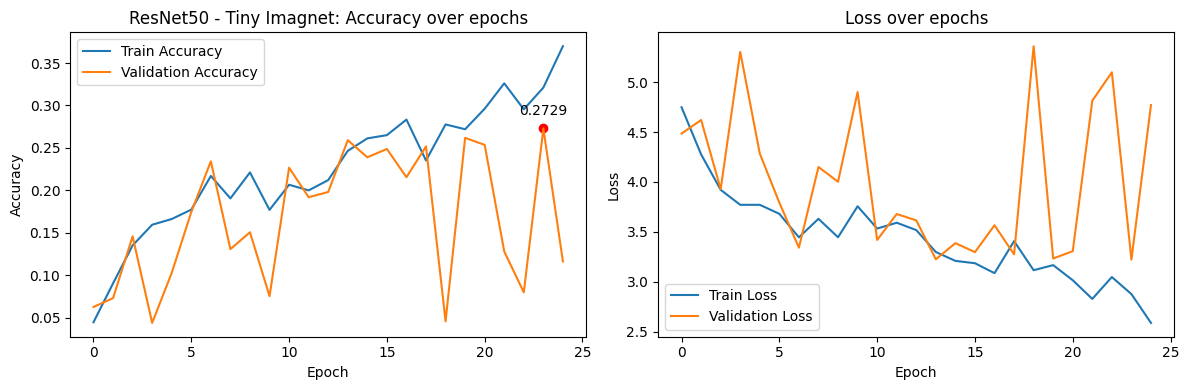

In [20]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(imagenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(imagenet_history.history['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(imagenet_history.history['val_accuracy'])
max_val_acc_idx = imagenet_history.history['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('ResNet50 - Tiny Imagnet: Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(imagenet_history.history['loss'], label='Train Loss')
plt.plot(imagenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## I honestly have no idea what I'm seeing here. I'll try adding another dense layer and increasing dropout to see if it helps

In [20]:
# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(.5),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(256, activation='relu'),
    Dropout(.5),
    Dense(200, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

imagenet_history = model.fit(
    tiny_imagenet_train_gen,
    epochs=25,
    validation_data=tiny_imagenet_val_gen,
    steps_per_epoch=tiny_imagenet_train_gen.samples // tiny_imagenet_train_gen.batch_size,
    validation_steps=tiny_imagenet_val_gen.samples // tiny_imagenet_val_gen.batch_size
)

Epoch 1/25
1250/1250 [==============================] - 34s 18ms/step - loss: 5.2805 - accuracy: 0.0080 - val_loss: 5.1332 - val_accuracy: 0.0098
Epoch 2/25
1250/1250 [==============================] - 22s 17ms/step - loss: 5.0587 - accuracy: 0.0154 - val_loss: 5.1453 - val_accuracy: 0.0137
Epoch 3/25
1250/1250 [==============================] - 22s 18ms/step - loss: 4.9157 - accuracy: 0.0215 - val_loss: 4.9631 - val_accuracy: 0.0261
Epoch 4/25
1250/1250 [==============================] - 21s 17ms/step - loss: 4.8534 - accuracy: 0.0255 - val_loss: 5.4488 - val_accuracy: 0.0128
Epoch 5/25
1250/1250 [==============================] - 21s 17ms/step - loss: 4.7871 - accuracy: 0.0310 - val_loss: 4.7586 - val_accuracy: 0.0380
Epoch 6/25
1250/1250 [==============================] - 22s 18ms/step - loss: 4.6680 - accuracy: 0.0399 - val_loss: 4.6274 - val_accuracy: 0.0495
Epoch 7/25
1250/1250 [==============================] - 23s 18ms/step - loss: 4.6182 - accuracy: 0.0455 - val_loss: 4.8903 -

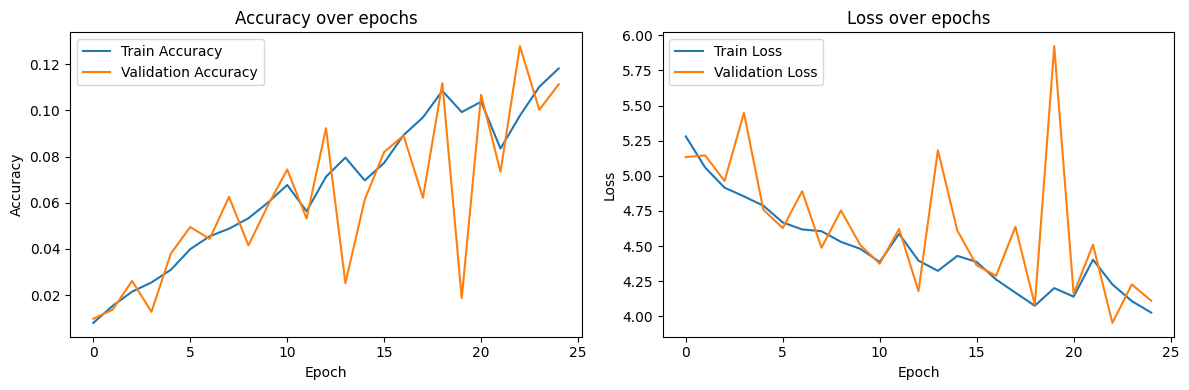

In [21]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(history.history['val_accuracy'])
max_val_acc_idx = history.history['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# MNIST

In [8]:
# Load and Preprocess data MNIST data
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

mnist_train_images = np.array([tf.image.resize(img[..., tf.newaxis], [32, 32]).numpy() for img in mnist_train_images])
mnist_test_images = np.array([tf.image.resize(img[..., tf.newaxis], [32, 32]).numpy() for img in mnist_test_images])

mnist_train_images = np.repeat(mnist_train_images, 3, axis=-1)
mnist_test_images = np.repeat(mnist_test_images, 3, axis=-1)

mnist_train_labels = to_categorical(mnist_train_labels)
mnist_test_labels = to_categorical(mnist_test_labels)

mnist_train_images = mnist_train_images / 255.0
mnist_test_images = mnist_test_images / 255.0

In [10]:
# Create callback for saving model
checkpoint = ModelCheckpoint('../models/resnet50_mnist.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(mnist_train_images, mnist_train_labels,
                    epochs=25,
                    batch_size=1024,
                    validation_data=(mnist_test_images, mnist_test_labels),
                    callbacks=[checkpoint])

Epoch 1/25
59/59 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9524
Epoch 1: val_accuracy improved from -inf to 0.11350, saving model to ../models/resnet50_mnist.h5
59/59 [==============================] - 15s 53ms/step - loss: 0.1734 - accuracy: 0.9524 - val_loss: 4.1412 - val_accuracy: 0.1135
Epoch 2/25
59/59 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9925
Epoch 2: val_accuracy did not improve from 0.11350
59/59 [==============================] - 3s 43ms/step - loss: 0.0247 - accuracy: 0.9925 - val_loss: 4.3302 - val_accuracy: 0.1135
Epoch 3/25
58/59 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9956
Epoch 3: val_accuracy did not improve from 0.11350
59/59 [==============================] - 3s 44ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 2.8403 - val_accuracy: 0.1135
Epoch 4/25
59/59 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9969
Epoch 4: val_accuracy did not impr

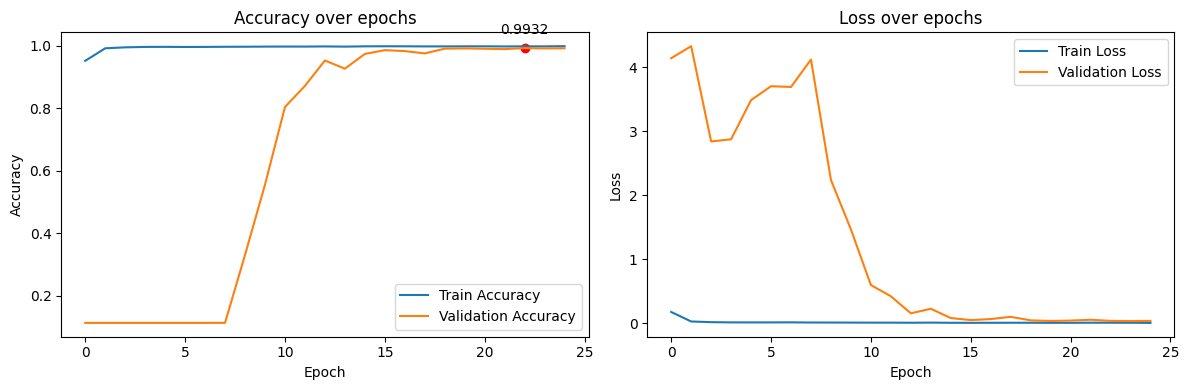

In [11]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(history.history['val_accuracy'])
max_val_acc_idx = history.history['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# CIFAR-10

In [3]:
# Load data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Preprocess data
cifar10_train_images = train_images.astype('float32') / 255
cifar10_test_images = test_images.astype('float32') / 255

cifar10_train_labels = to_categorical(train_labels)
cifar10_test_labels = to_categorical(test_labels)

In [5]:
# Create callback for saving model
checkpoint = ModelCheckpoint('../models/resnet50_cifar10.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(.4),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(cifar10_train_images, cifar10_train_labels,
                    epochs=40,
                    batch_size=1024,
                    validation_data=(cifar10_test_images, cifar10_test_labels),
                    callbacks=[checkpoint])

Epoch 1/40
49/49 [==============================] - ETA: 0s - loss: 1.3223 - accuracy: 0.5733
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to ../models/resnet50_cifar10.h5


/home/robert/Dev/cs5870-assignment-1/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 14s 56ms/step - loss: 1.3223 - accuracy: 0.5733 - val_loss: 3.7146 - val_accuracy: 0.1000
Epoch 2/40
49/49 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.7885
Epoch 2: val_accuracy did not improve from 0.10000
49/49 [==============================] - 2s 43ms/step - loss: 0.6262 - accuracy: 0.7885 - val_loss: 2.5969 - val_accuracy: 0.1000
Epoch 3/40
49/49 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.8601
Epoch 3: val_accuracy did not improve from 0.10000
49/49 [==============================] - 2s 43ms/step - loss: 0.4186 - accuracy: 0.8601 - val_loss: 3.0966 - val_accuracy: 0.1000
Epoch 4/40
49/49 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.9014
Epoch 4: val_accuracy improved from 0.10000 to 0.10350, saving model to ../models/resnet50_cifar10.h5
49/49 [==============================] - 3s 51ms/step - loss: 0.2951 - accuracy: 0.9014 - val_loss: 2.7778 - val_accuracy: 

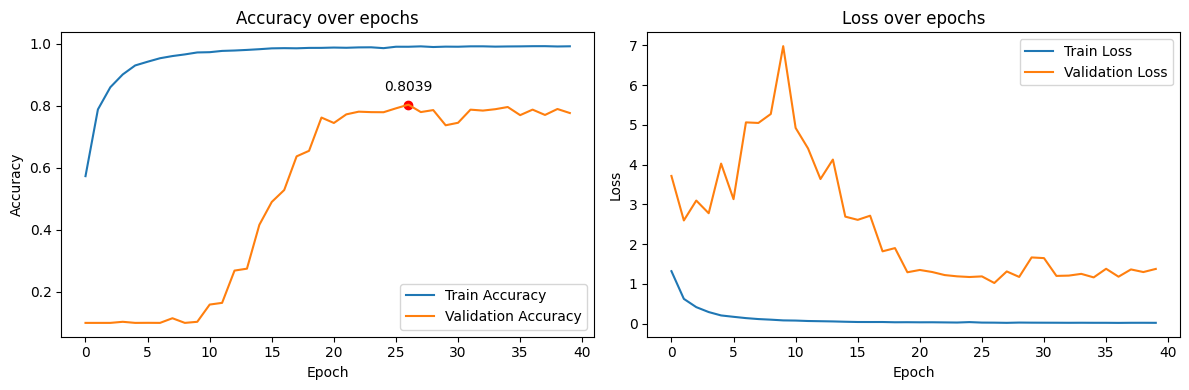

In [6]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Annotate the maximum validation accuracy
max_val_acc = max(history.history['val_accuracy'])
max_val_acc_idx = history.history['val_accuracy'].index(max_val_acc)
plt.scatter(max_val_acc_idx, max_val_acc, color='red') # Highlight the max value with a red dot
plt.annotate(f'{max_val_acc:.4f}', (max_val_acc_idx, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center') # Annotate the value

plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
